In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar

MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)


In [2]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model = (pm.HillasGaisser2012, "H3a"),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
)

#Power of energy to scale the flux
mag = 3

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))



log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])



MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


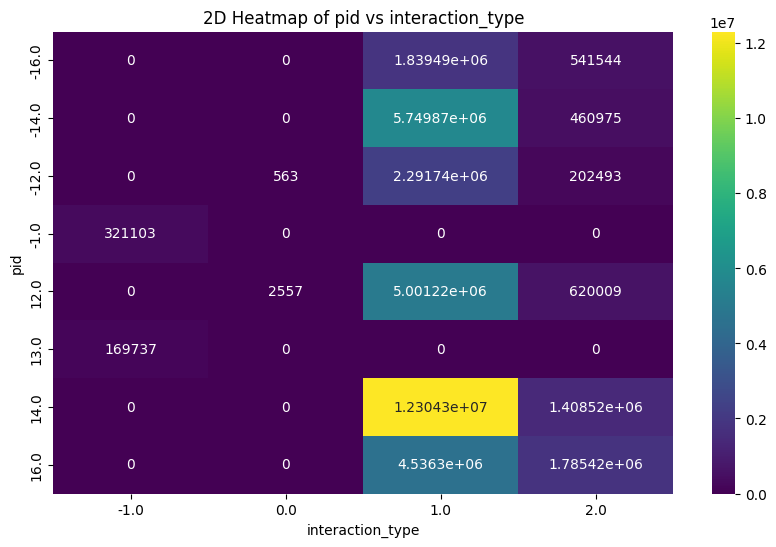

In [3]:
import seaborn as sns

plt.figure(figsize=(10, 6))
heatmap_data = pd.crosstab(db_MC_neutrinos['pid'], db_MC_neutrinos['interaction_type'])
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.xlabel('interaction_type')
plt.ylabel('pid')
plt.title('2D Heatmap of pid vs interaction_type')
plt.show()

In [5]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 1 GeV
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos


# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges


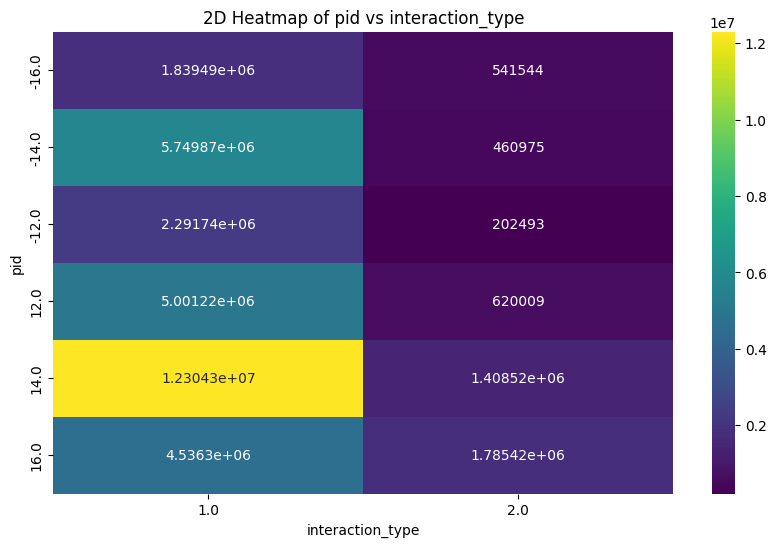

18054122
1869497


In [6]:
import seaborn as sns

plt.figure(figsize=(10, 6))
heatmap_data = pd.crosstab(db_MC_neutrinos_cut['pid'], db_MC_neutrinos_cut['interaction_type'])
sns.heatmap(heatmap_data, annot=True, fmt='g', cmap='viridis')
plt.xlabel('interaction_type')
plt.ylabel('pid')
plt.title('2D Heatmap of pid vs interaction_type')
plt.show()

print(sum((abs(db_MC_neutrinos_cut['pid']) == 14) & (db_MC_neutrinos_cut['interaction_type'] == 1)))
print(sum((abs(db_MC_neutrinos_cut['pid']) == 14) & (db_MC_neutrinos_cut['interaction_type'] == 2)))

In [6]:
db_MC_neutrinos_cut.columns

Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')

In [7]:
#db_MC_neutrinos_cut.describe()

In [7]:
# Unweighted counts
nc_count = (db_MC_neutrinos_cut['interaction_type'] == 2).sum() #NC
cc_count = (db_MC_neutrinos_cut['interaction_type'] == 1).sum() #CC 
R_unweighted = nc_count / cc_count
print("Unweighted R (NC/CC) =", R_unweighted)

nc_weight = db_MC_neutrinos_cut.loc[db_MC_neutrinos_cut['interaction_type'] == 2, 'total_osc_weight'].sum() #NC
cc_weight = db_MC_neutrinos_cut.loc[db_MC_neutrinos_cut['interaction_type'] == 1, 'total_osc_weight'].sum() #CC
R_weighted = nc_weight / cc_weight
print("Weighted R (NC/CC) =", R_weighted)

#1 = CC, 2 = NC

Unweighted R (NC/CC) = 0.15821263805184804
Weighted R (NC/CC) = 0.11157866341279805


In [10]:
track_cut = 0.5  

s2tlist = []
ratiolist = []

freq_list = []

true_muon_to_total_list = []
pred_muon_to_total_list = []

tau_list = []
muon_list = []
elec_list = []

track_list = []

track_right_list = []
track_wrong_list = []

track_muons = []  
casc_muons = []  

true_muon_NCCC_ratio = []
pred_muon_NCCC_ratio = []

VeCC = []
VeNC = []
VuCC = []
VuNC = []
VtCC = []
VtNC = []

for i in range(len(log_bincenters)):
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    track = (db_in_bin['track_mu_pred'] > track_cut)
    casc = (db_in_bin['track_mu_pred'] <= track_cut)

    true_taus = len(db_in_bin[abs(db_in_bin['pid']) == 16])
    true_muons = len(db_in_bin[abs(db_in_bin['pid']) == 14])
    true_elecs = len(db_in_bin[abs(db_in_bin['pid']) == 12])

    pred_neutrinos = len(db_in_bin['pid_neutrino_pred'])

    track_right_list.append(len(db_in_bin[track & (abs(db_in_bin['pid']) == 14) & (db_in_bin['interaction_type'] == 1)]))
    track_wrong_list.append(len(db_in_bin[track & (db_in_bin['interaction_type'] == 2)]))

    tau_list.append(true_taus)
    muon_list.append(true_muons)
    elec_list.append(true_elecs)

    track_list.append(sum(track))
    freq_list.append(len(db_in_bin))

    track_muons = len(db_in_bin[(db_in_bin['interaction_type'] == 2) & (abs(db_in_bin['pid']) == 14)])
    casc_muons = len(db_in_bin[(db_in_bin['interaction_type'] == 1) & (abs(db_in_bin['pid']) == 14)])

    true_muon_to_total_list.append(true_muons / (true_taus+true_muons+true_elecs))
    pred_muon_to_total_list.append(sum(track) / pred_neutrinos)

    true_muon_NCCC_ratio.append(track_muons / casc_muons if casc_muons > 0 else 0)
    pred_muon_NCCC_ratio.append(sum(track) / sum(casc) if sum(casc) > 0 else 0)

    ratiolist.append((true_muon_NCCC_ratio, pred_muon_NCCC_ratio))

    VeCC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 1) & (db_in_bin['pid'] == 12)]))
    VeNC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 2) & (db_in_bin['pid'] == 12)]))
    VuCC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 1) & (db_in_bin['pid'] == 14)]))
    VuNC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 2) & (db_in_bin['pid'] == 14)]))
    VtCC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 1) & (abs(db_in_bin['pid']) == 16)]))
    VtNC.append(len(db_in_bin[(db_in_bin['interaction_type'] == 2) & (abs(db_in_bin['pid']) == 16)]))
                    

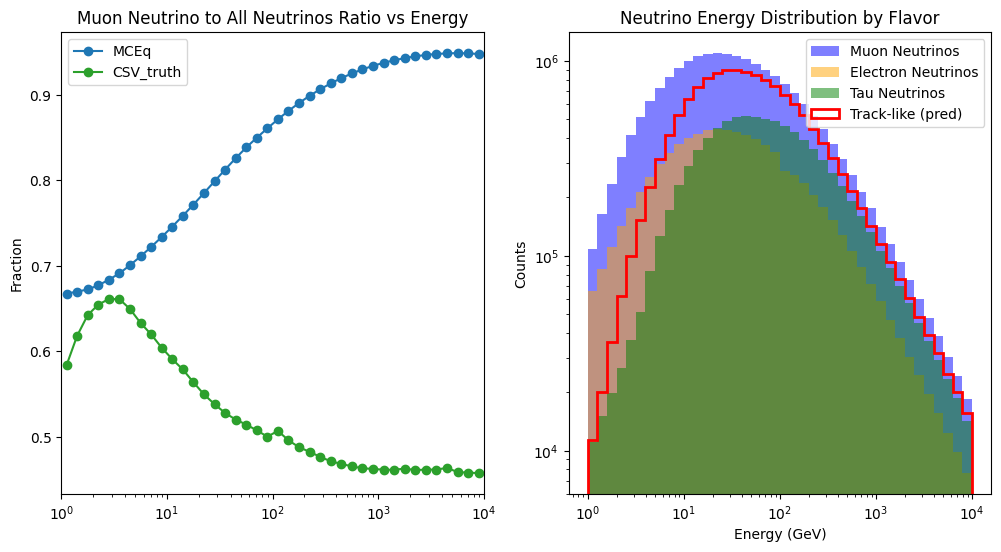

In [11]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')

ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')

ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV_truth', color='tab:green')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].hist(db_MC_neutrinos_cut[db_MC_neutrinos_cut['track_mu_pred'] > track_cut]['energy'], bins=bins, histtype='step', linewidth=2, label='Track-like (pred)', color='red')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor')
ax[1].legend()


## so, blue line is expected and wanted % of muon neutrinos in the dataset. 
## too little muons, and of the muons, too many are CC.


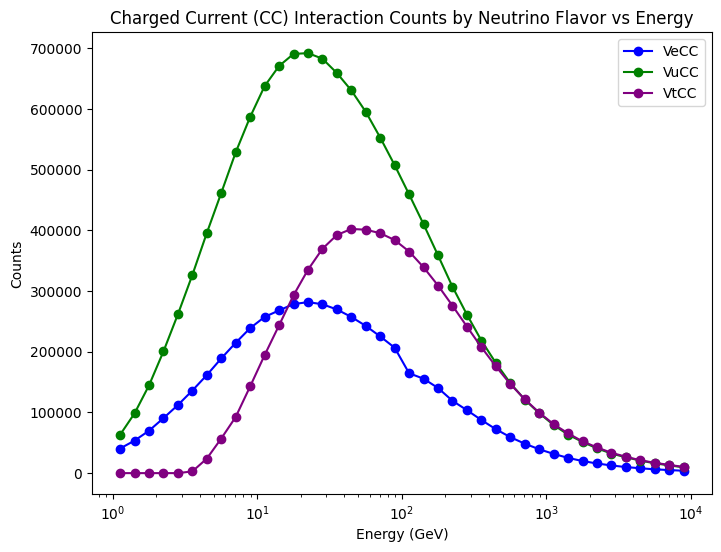

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(log_bincenters, VeCC, marker='o', label='VeCC', color='blue')
ax.plot(log_bincenters, VeNC, marker='o', label='VeNC', color='orange')
ax.plot(log_bincenters, VuCC, marker='o', label='VuCC', color='green')
ax.plot(log_bincenters, VuNC, marker='o', label='VuNC', color='red')
ax.plot(log_bincenters, VtCC, marker='o', label='VtCC', color='purple')
ax.plot(log_bincenters, VtNC, marker='o', label='VtNC', color='brown')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Counts')
ax.set_title('Charged Current (CC) Interaction Counts by Neutrino Flavor vs Energy')
ax.set_xscale('log')
ax.legend()
plt.show()

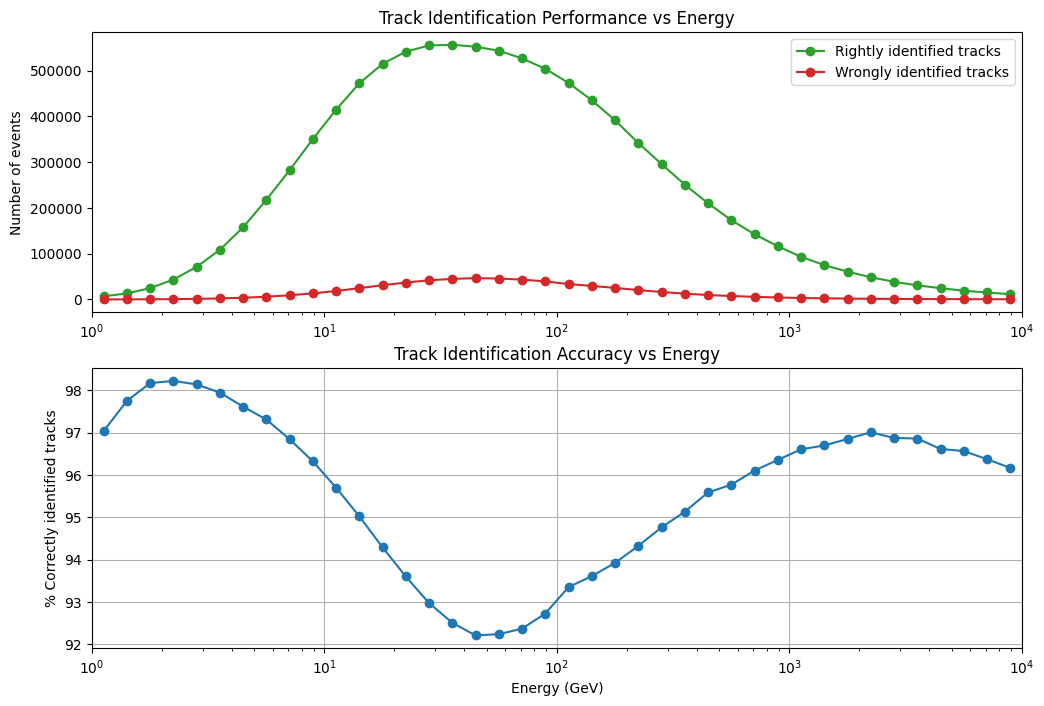

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

# First plot: counts
ax[0].plot(log_bincenters, track_right_list, marker='o', label='Rightly identified tracks', color='tab:green')
ax[0].plot(log_bincenters, track_wrong_list, marker='o', label='Wrongly identified tracks', color='tab:red')
ax[0].set_ylabel('Number of events')
ax[0].set_title('Track Identification Performance vs Energy')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

# Second plot: % correct
percent_correct = np.array(track_right_list) / (np.array(track_right_list) + np.array(track_wrong_list)) * 100
ax[1].plot(log_bincenters, percent_correct, marker='o', color='tab:blue')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_ylabel('% Correctly identified tracks')
ax[1].set_title('Track Identification Accuracy vs Energy')
ax[1].set_xlim([1, 10000])
ax[1].set_xscale('log')
ax[1].grid(True)

#this is to test the muon neutrino == track hypothesis  

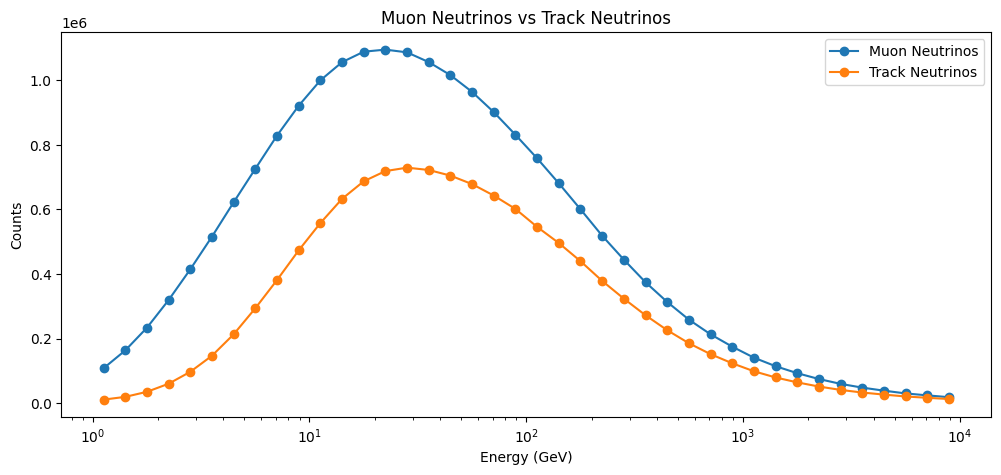

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(log_bincenters, muon_list, marker='o', label='Muon Neutrinos', color='tab:blue')
ax.plot(log_bincenters, track_list, marker='o', label='Track Neutrinos', color='tab:orange')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('Counts')
ax.set_title('Muon Neutrinos vs Track Neutrinos')
ax.set_xscale('log')
ax.legend()

In [14]:
import scipy.optimize as opt

def ratio(sin2theta, r):
    gl2 = 1/2 - sin2theta + 5/9*sin2theta**2
    gr2 = r*5/9*sin2theta**2
    return gl2+gr2

def dif_rsq(sin2theta, r, target):
    return (ratio(sin2theta, r) - target)**2


res_list = []
for R_meas in ratiolist:
    res = opt.minimize_scalar(dif_rsq, bounds=(0, 1), args=(0.3, R_meas), method='bounded')
    res_list.append(res.x)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(log_bincenters, s2tlist, marker='o')
ax[0].plot(log_bincenters, res_list, marker='o', label='Numerical Inversion', color='red')
ax[0].set_xscale('log') 
ax[0].set_xlabel('Energy (GeV)')
ax[0].set_ylabel('sin²(θ)')
ax[0].set_title('sin²(θ) vs Energy')
ax[1].plot(log_bincenters, ratiolist, marker='o', color='orange')
ax[1].set_xscale('log')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_ylabel('Cascade/Track Ratio')
ax[1].set_title('Cascade/Track Ratio vs Energy')
plt.grid()  
plt.show()